## Trench migration figures.

Generate figures for trench migration.

In [1]:
from __future__ import print_function

import pygplates
from ptt import subduction_convergence as sc
import numpy as np
import os.path
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True

# Ignore warnings in subduction convergence script.
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

#model_dir = 'Global_Model_WD_Internal_Release_2019_v3'
model_dir = 'Global_1000-0_Model_2017'

if model_dir.startswith('Global_Model_WD_Internal_Release'):
    # Define the time snapshots at which to get the subduction zone properties
    min_time = 0
    max_time = 410
    
    model_name = 'run2_240-250adj'
    
    rotation_base_filenames = [
        'Alps_Mesh_Rotations_2019_v2',
        'Andes_Flat_Slabs_Rotations_2019_v2',
        'Andes_Rotations_2019_v2',
        'Australia_Antarctica_Mesh_Rotations_2019_v2',
        'Australia_North_Zealandia_Rotations_2019_v2',
        'Eurasia_Arabia_Mesh_Rotations_2019_v2',
        'Global_250-0Ma_Rotations_2019_v2',
        'Global_410-250Ma_Rotations_2019_v2',
        'North_America_Flat_Slabs_Rotations_2019_v2',
        'North_America_Mesh_Rotations_2019_v2',
        'North_China_Mesh_Rotations_2019_v2',
        'Southeast_Asia_Rotations_2019_v2',
        'South_Atlantic_Rotations_2019_v2',
        'South_China_DeformingModel_xianzhi',
    ]
elif model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots at which to get the subduction zone properties
    min_time = 0
    max_time = 1000
    
    model_name = 'git_20210802_ce53d67_run45'
    
    rotation_base_filenames = ['1000_0_rotfile_Merdith_et_al']
else:
    # Define the time snapshots at which to get the subduction zone properties
    min_time = 0.
    max_time = 410.
    
    model_name = ''
    
    rotation_base_filenames = []

input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]

optimised_rotation_filenames = [
        os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
            for rotation_base_filename in rotation_base_filenames]


# Topologies to be used with the subduction_convergence script
if model_dir == 'Global_1000-0_Model_2017':
    # Starting at SVN rev 1624 there are other GPML files that we don't need to include.
    topology_base_filenames = [
        '250-0_plate_boundaries_Merdith_et_al.gpml',
        '410-250_plate_boundaries_Merdith_et_al.gpml',
        '1000-410-Convergence_Merdith_et_al.gpml',
        '1000-410-Divergence_Merdith_et_al.gpml',
        '1000-410-Topologies_Merdith_et_al.gpml',
        '1000-410-Transforms_Merdith_et_al.gpml',
        'TopologyBuildingBlocks_Merdith_et_al.gpml',
    ]
    topology_filenames = [os.path.join(input_dir, topology_base_filename)
            for topology_base_filename in topology_base_filenames]
else:
    topology_filenames = glob.glob(os.path.join(input_dir, '*.gpml'))


# specify time range and resolution for plots
threshold_sampling_distance_radians = np.radians(0.5)

# Set the delta time for velocity calculations
velocity_delta_time = 1.

# Typically the achor plate id should be 0
anchor_plate_id = 0

2.2.0.32


## Generate subduction Zone Kinematics

In [2]:
# Do the number crunching
# Create a dataframe that contains all subduction data for full sequence of time steps

# Data frame template defining the column names
DataFrameTemplate = ('lon','lat','conv_rate','conv_obliq','migr_rate',
                     'migr_obliq','arc_length','arc_azimuth',
                     'subducting_plate','overriding_plate','time')

time_step = 1

def get_subduction_stats(
        rotation_filenames,
        topology_filenames):
    
    # Create an empty dataframe to concatenate results to
    df_AllTimes = pd.DataFrame(columns=DataFrameTemplate)

    # list of reconstruction times
    reconstruction_times = range(min_time, max_time+1, time_step)

    rotation_model = pygplates.RotationModel(rotation_filenames)
    topology_features = [pygplates.FeatureCollection(file) for file in topology_filenames]

    # Iterate over time steps
    for reconstruction_time in reconstruction_times:

        # Get the subduction kinematics database 
        subduction_data = []
        output_data = sc.subduction_convergence(
                    rotation_model,
                    topology_features,
                    threshold_sampling_distance_radians,
                    reconstruction_time,
                    velocity_delta_time,
                    anchor_plate_id)

        # Make a flat list of subduction stats to input into the proximity test
        for data in output_data:
            subduction_data.append(data[:10]+(reconstruction_time,))

        # convert list array to dataframe
        df = pd.DataFrame(subduction_data, columns = DataFrameTemplate)

        # append dataframe 
        df_AllTimes = df_AllTimes.append(df)
        
    return df_AllTimes  

In [3]:
# Output subduction table for non-optimised model
original_subduction_table_filename = os.path.join(
    output_dir, 'Deformation_NoOpt_SubductionTable_%0.0f_%0.0fMa.csv' % (min_time, max_time))

# Output subduction table for optimised model
optimised_subduction_table_filename = os.path.join(
    output_dir, 'Deformation_%s_SubductionTable_%0.0f_%0.0fMa.csv' % (model_name, min_time, max_time))


# Non-optimised stats.
df_no_opt = get_subduction_stats(original_rotation_filenames, topology_filenames)
df_no_opt.to_csv(original_subduction_table_filename)
#df_no_opt = pd.read_csv(original_subduction_table_filename)

# Optimised stats.
df_opt = get_subduction_stats(optimised_rotation_filenames, topology_filenames)
df_opt.to_csv(optimised_subduction_table_filename)
#df_opt = pd.read_csv(optimised_subduction_table_filename)

In [4]:
def init_df(df):
    mr = np.asarray(df['migr_rate'])
    mo = np.asarray(df['migr_obliq'])

    cr = np.asarray(df['conv_rate'])
    co = np.asarray(df['conv_obliq'])

    # NOTE
    # the absolute velocity magnitude is negative if the subduction zone (trench)
    # is moving towards the overriding plate (if absolute motion obliquity angle is less than 90 or greater than -90)
    # So, to get the orthogonal migration, we actually ignore the sign of the migration rate, since the obliquity
    # angle also distinguishes between trench advance and retreat (full range is -180 to +180)
    df['ortho_migr_rate'] = pd.Series(np.abs(mr)*-np.cos(np.radians(mo)), index=df.index)

    df['ortho_conv_rate'] = pd.Series(cr*np.abs(np.cos(np.radians(co))), index=df.index)

init_df(df_no_opt)
init_df(df_opt)

## Plot subduction Zone Kinematics

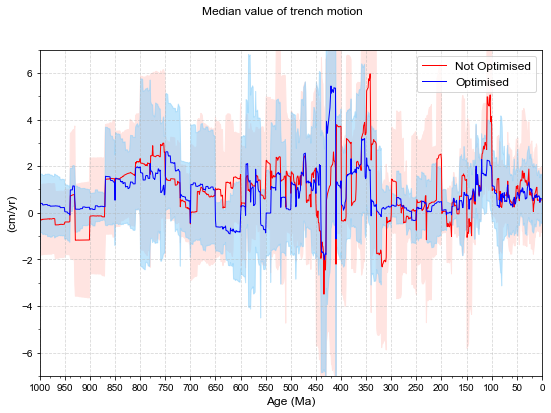

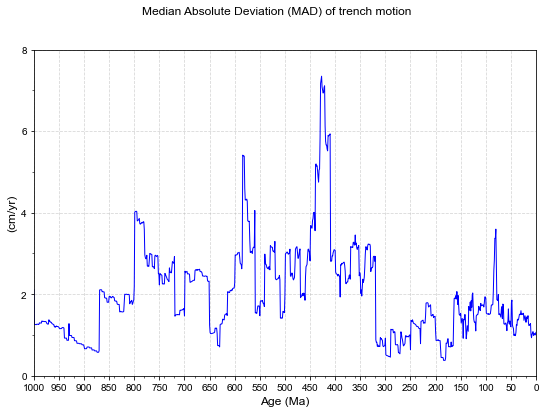

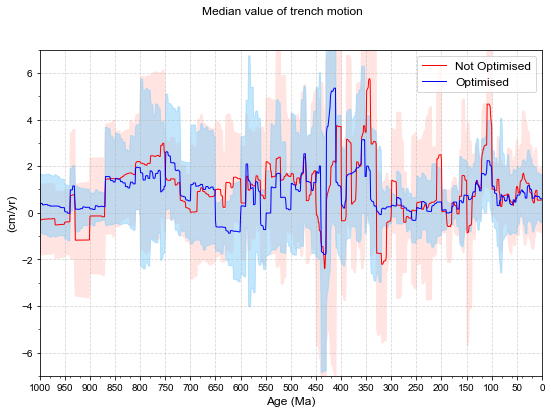

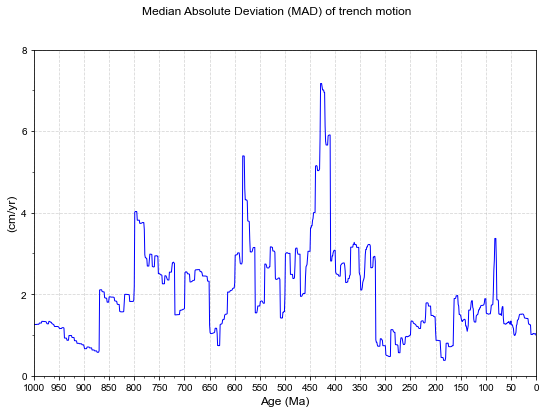

In [5]:
%matplotlib inline

time_step = 1

def plot_trench_motion(
        trench_motion_plot_title,
        trench_motion_plot_filename,
        trench_motion_MAD_plot_title,
        trench_motion_MAD_plot_filename,
        medfilt_kernel_size):
    
    all_medians_opt = []
    all_medians_no_opt = []
    
    all_median_abs_deviations_opt = []
    all_median_abs_deviations_no_opt = []

    TimeStepList = range(min_time, max_time + time_step, time_step)
    for TIME in TimeStepList:
        subset_opt = df_opt[(df_opt['time']>=TIME) & (df_opt['time']<(TIME+time_step))]
        subset_no_opt = df_no_opt[(df_no_opt['time']>=TIME) & (df_no_opt['time']<(TIME+time_step))]

        median_ortho_migr_rate_opt = subset_opt['ortho_migr_rate'].median()
        median_ortho_migr_rate_no_opt = subset_no_opt['ortho_migr_rate'].median()

        median_abs_deviation_ortho_migr_rate_opt = abs(
            subset_opt['ortho_migr_rate'] - median_ortho_migr_rate_opt).median()
        median_abs_deviation_ortho_migr_rate_no_opt = abs(
            subset_no_opt['ortho_migr_rate'] - median_ortho_migr_rate_no_opt).median()

        all_medians_opt.append(median_ortho_migr_rate_opt)
        all_medians_no_opt.append(median_ortho_migr_rate_no_opt)

        all_median_abs_deviations_opt.append(median_abs_deviation_ortho_migr_rate_opt)
        all_median_abs_deviations_no_opt.append(median_abs_deviation_ortho_migr_rate_no_opt)

    def common_figure_setup(fig, ax):
        ax.set_xticks(np.arange(0, max_time+1, 50))
        ax.set_xticks(np.arange(0, max_time+1, 20), minor=True)
        ax.set_yticks(np.arange(-10, 10+1, 2))
        ax.set_yticks(np.arange(-10, 10+1, 1), minor=True)

        plt.ylabel('(cm/yr)',fontsize=12)
        plt.xlim((0,max_time))
        plt.xlabel('Age (Ma)',fontsize=12)
        #plt.gca().yaxis.grid(True,which='major')
        plt.grid(linestyle='--',alpha=0.5)

    #
    # Plot trench motion
    #
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    common_figure_setup(fig, ax)
    fig.suptitle(trench_motion_plot_title)
    plt.ylim((-7,7))
    plt.gca().invert_xaxis() # Time should go from left to right.
        
    plt.fill_between(
        TimeStepList,
        medfilt(np.array(all_medians_no_opt) + np.array(all_median_abs_deviations_no_opt), medfilt_kernel_size),
        medfilt(np.array(all_medians_no_opt) - np.array(all_median_abs_deviations_no_opt), medfilt_kernel_size),
        color='mistyrose')
        #color=(0.1, 0.0, 0.0))

    plt.fill_between(
        TimeStepList,
        medfilt(np.array(all_medians_opt) + np.array(all_median_abs_deviations_opt), medfilt_kernel_size),
        medfilt(np.array(all_medians_opt) - np.array(all_median_abs_deviations_opt), medfilt_kernel_size),
        color='lightskyblue',
        #color=(0.0, 0.0, 0.1),
        alpha=0.5)

    plt.plot(
        TimeStepList,
        medfilt(np.array(all_medians_no_opt), medfilt_kernel_size),
        'r',
        label='Not Optimised',
        #label='Optimised (TR=1, NR=0.5)',
        linewidth=1)
    plt.plot(
        TimeStepList,
        medfilt(np.array(all_medians_opt), medfilt_kernel_size),
        'b',
        label='Optimised',
        #label='Optimised (HS=1, TR, NR=0.5)',
        linewidth=1)
    
    plt.legend(fontsize=12)
    plt.savefig(trench_motion_plot_filename, format='pdf', dpi=600)
    plt.show()

    
    #
    # Plot trench motion median absolute deviation (MAD)
    #
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    common_figure_setup(fig, ax)
    fig.suptitle(trench_motion_MAD_plot_title)
    plt.ylim((0,8))
    plt.gca().invert_xaxis() # Time should go from left to right.

    plt.plot(
        TimeStepList,
        medfilt(np.array(all_median_abs_deviations_opt), medfilt_kernel_size),
        'b',
        linewidth=1)
    
    plt.savefig(trench_motion_MAD_plot_filename, format='pdf', dpi=600)
    plt.show()


#medfilt_kernel_sizes = [1,3,5]
medfilt_kernel_sizes = [1,5]

for medfilt_kernel_size in medfilt_kernel_sizes:
    plot_trench_motion(
        'Median value of trench motion',
        os.path.join(output_dir, 'trench_motion_%s_%dMy.pdf' % (model_name, medfilt_kernel_size)),
        'Median Absolute Deviation (MAD) of trench motion',
        os.path.join(output_dir, 'trench_motion_MAD_%s_%dMy.pdf' % (model_name, medfilt_kernel_size)),
        medfilt_kernel_size)


In [6]:
time_step = 5

from mpltools import color
# Set Colorbar
bcr_rgba = [(0.4, 0.0, 0.1, 1),
                (1.0, 1.0, 1.0, 1),
                (1.0, 1.0, 1.0, 1),
            (0.02,  0.2, 0.4, 1)]
blue_clear_red = color.LinearColormap('blue_clear_red', bcr_rgba,
                                      index=[0, 0.5, 0.5, 1])

VMIN = -15000
VMAX = 15000

def plot_ortho_migration_rate_histogram(df, plot_filename):
    
    #plt.figure(figsize=(9,6))
    #def MakeTimeDependentHistogram(df_tmp):

    fig = plt.figure(figsize=(7.5,5))
    ax1 = fig.add_axes([0.1, 0.3, 0.85, 0.65])

    TimeStepList = np.arange(min_time,max_time+time_step,time_step)
    VelBins = np.arange(-15,15,1.0)
    histCat = np.zeros((len(TimeStepList),len(VelBins)))
    count = 0
    for TIME in TimeStepList:
        subset = df[(df['time']>=TIME) & (df['time']<(TIME+time_step))]

        #print(TIME)
        #print subset['arc_length'].sum()*111/time_step

        tmp = []
        for Bin in VelBins:
            subset_bin = subset[(subset['ortho_migr_rate']>=Bin) & (subset['ortho_migr_rate']<(Bin+1.0))]
            tmp.append(subset_bin['arc_length'].sum()*111/time_step)
        histCat[count,:] = tmp

        #print np.sum(tmp)

        #tmp = np.histogram(subset['ortho_migr_rate'],bins=VelBins)
        #histCat[count,:] = 100*np.double(tmp[0].T)/np.asarray(subset['ortho_migr_rate']).shape[0]
        count=count+1

    histCat[:,0:len(VelBins)//2] = histCat[:,0:len(VelBins)//2]*-1

    ax1.pcolor(TimeStepList, VelBins, histCat.T,cmap=blue_clear_red,vmin=VMIN,vmax=VMAX)
    ax1.set_xlim([min_time,max_time])
    ax1.set_ylim([-10,10])
    ax1.set_yticks([-10, -5, 0, 5, 10])
    plt.ylabel('Trench-othogonal migration rate (cm/yr)', fontsize=12)
    plt.xlabel('Reconstruction Age (Myr)', fontsize=12)
    plt.grid(linestyle='--',alpha=0.5)
    plt.gca().invert_xaxis() # Time should go from left to right.

    # Colorbars - make spearate scales for trench advance and trench retreat
    ax2 = fig.add_axes([0.15, 0.145, 0.55, 0.03])
    bc_rgba = [(1.0, 1.0, 1.0, 1), 
               (0.02,  0.2, 0.4, 1)]
    blue_clear = color.LinearColormap('blue_clear', bc_rgba,
                                          index=[0, 1])
    norm = mpl.colors.Normalize(vmin=0, vmax=VMAX)
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=blue_clear,
                                       norm=norm,
                                       extend='max',
                                       ticks=[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000],
                                       #ticklabels=[],
                                       orientation='horizontal')
    cb1.ax.set_xticklabels([])
    plt.text(1.07,0.5,'Trench Retreat', verticalalignment='center',horizontalalignment='left',fontsize=12, transform=ax2.transAxes)

    ax3 = fig.add_axes([0.15, 0.1, 0.55, 0.03])
    rc_rgba = [(1.0, 1.0, 1.0, 1),
               (0.4, 0.0, 0.1, 1)]
    red_clear = color.LinearColormap('red_clear', rc_rgba,
                                          index=[0, 1])
    norm = mpl.colors.Normalize(vmin=0, vmax=VMAX)
    cb2 = mpl.colorbar.ColorbarBase(ax3, cmap=red_clear,
                                       norm=norm,
                                       extend='max',
                                       ticks=[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000],
                                       orientation='horizontal')
    #cb2.ax.set_xticklabels(['a', 'b'])
    plt.text(1.07,0.5,'Trench Advance', verticalalignment='center',horizontalalignment='left', fontsize=12, transform=ax3.transAxes)

    cb2.set_label('subduction length in bin (km)',fontsize=12)

    # Commenting out 'tight_layout()' since it raises exception (on my Windows system).
    # Using above manually-specified 'ticks' argument in 'cb1' and 'cb2' to reproduce close to same result as Simon.
    #
    #fig.tight_layout(w_pad=1,h_pad=1)
    #MakeTimeDependentHistogram(df)

    plt.savefig(plot_filename,format='pdf',dpi=600)

    plt.show()


#plot_ortho_migration_rate_histogram(df_no_opt, os.path.join(output_dir, 'trenchmigration_NoOpt.pdf'))
plot_ortho_migration_rate_histogram(df_opt, os.path.join(output_dir, 'trenchmigration_%s.pdf' % model_name))

ModuleNotFoundError: No module named 'mpltools'